## Project 2

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import sklearn
from sklearn import model_selection
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras import backend as K
from keras import optimizers
from keras.callbacks import EarlyStopping

from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from scipy.interpolate import interp1d
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import roc_auc_score, roc_curve, auc, r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from numpy import linalg as LA
from scipy.stats import skew
from numpy.polynomial import polynomial as P
from sklearn.model_selection import cross_val_score

Using TensorFlow backend.


In [2]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 42

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

In [3]:
Features  = ["Age","EtCO2","PTT","BUN","Lactate","Temp",
"Hgb","HCO3","BaseExcess","RRate","Fibrinogen","Phosphate",
"WBC","Creatinine","PaCO2","AST","FiO2","Platelets","SaO2","Glucose",
"ABPm","Magnesium","Potassium","ABPd","Calcium","Alkalinephos","SpO2","Bilirubin_direct",
"Chloride","Hct","Heartrate","Bilirubin_total","TroponinI","ABPs","pH"]

# Feature_index = np.array([1,5,8,12,16,21]) #BaseExcess
# Feature_index = np.array([5,8,16,34]) #BaseExcess
# Feature_index = np.array([1,5,8,16,21,24,34]) #BaseExcess
# Feature_index = np.array([5,8,16,21,34])# Fribrinogen
# Feature_index = np.array([5,8,16,21,27,34])# AST
# Feature_index = np.array([5,15,16,34])# Sepsis

# Feature_index = np.array([1,5,8,9,16,17]) # fibriogenin
# Feature_index = np.array([0,4,6,7,10,11])
# Feature_index = np.array([5,8,9,15,16,21,17,34])# Sepsis correlation
# Selected = [Features[i] for i in Feature_index]
Selected = Features

In [4]:
print(Selected)

['Age', 'EtCO2', 'PTT', 'BUN', 'Lactate', 'Temp', 'Hgb', 'HCO3', 'BaseExcess', 'RRate', 'Fibrinogen', 'Phosphate', 'WBC', 'Creatinine', 'PaCO2', 'AST', 'FiO2', 'Platelets', 'SaO2', 'Glucose', 'ABPm', 'Magnesium', 'Potassium', 'ABPd', 'Calcium', 'Alkalinephos', 'SpO2', 'Bilirubin_direct', 'Chloride', 'Hct', 'Heartrate', 'Bilirubin_total', 'TroponinI', 'ABPs', 'pH']


In [5]:
# Read Data and process data
file_features = pd.read_csv('train_features.csv')
file_labels = pd.read_csv('train_labels.csv')
data_features = file_features.values
data_labels  = file_labels.values

num_patient = data_features.shape[0]//12
data_train = np.zeros([num_patient,12,data_features.shape[1]])
# print(data_train.shape)

feature_selected = file_features.loc[:,Selected].values
Time = file_features.loc[:,'Time'].values
# print(feature_selected)

column_mean = np.nanmean(feature_selected, axis=0)
# print(column_mean)


# Read Data and process data
file_test = pd.read_csv('test_features.csv')
data_test = file_test.values
num_test = data_test.shape[0]//12
data_test = np.zeros([num_test,12,data_test.shape[1]])

feature_test_selected = file_test.loc[:,Selected].values
Time_test = file_test.loc[:,'Time'].values

In [6]:
num_measurement = np.zeros([num_patient,len(Selected)])
num_measurement_test = np.zeros([num_test,len(Selected)])


data = feature_selected.reshape(num_patient,12,-1)
# print(data[0,:,:])
print(feature_selected.shape)

for i in range(num_patient):
    num_measurement[i,:] = np.count_nonzero(~np.isnan(data[i,:,:]),axis=0)
    
print(num_measurement[0,:])    

data_test = feature_test_selected.reshape(num_test,12,-1)
for i in range(num_test):
    num_measurement_test[i,:] = np.count_nonzero(~np.isnan(data_test[i,:,:]),axis=0)

(227940, 35)
[12.  0.  0.  3.  0.  8.  3.  3.  6. 12.  0.  1.  3.  1.  3.  0.  4.  1.
  0.  1. 12.  5.  3. 12.  1.  0. 12.  0.  3.  6. 12.  0.  0. 12.  7.]


In [7]:
# Imputation
# imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
# imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

feature_selected = feature_selected.reshape(num_patient,12,-1)
feature_test_selected = feature_test_selected.reshape(num_test,12,-1)
Time = Time.reshape(num_patient,12)
Time_test = Time_test.reshape(num_test,12)
data = np.zeros([num_patient,5*len(Selected)])


mean_mat = np.zeros([num_patient,len(Selected)])
for i in range(num_patient):
    mean_mat[i,:] = np.nanmean(feature_selected[i,:,:],axis=0)
#     mean_mat[i,:] = LA.norm(data_imputated[i,:,:],axis=0)

var_mat = np.zeros([num_patient,len(Selected)])
for i in range(num_patient):
    var_mat[i,:] = np.nanvar(feature_selected[i,:,:],axis=0)
    
max_mat = np.zeros([num_patient,len(Selected)])
for i in range(num_patient):
    max_mat[i,:] = np.nanmax(feature_selected[i,:,:],axis=0)   
    
min_mat = np.zeros([num_patient,len(Selected)])
for i in range(num_patient):
    min_mat[i,:] = np.nanmin(feature_selected[i,:,:],axis=0)    

A_mat = np.zeros([num_patient,len(Selected)])
b_mat = np.zeros([num_patient,len(Selected)])
for i in range(num_patient):
    for j in range(len(Selected)):
        c = np.zeros([2])
        Value = feature_selected[i,~np.isnan(feature_selected[i,:,j]),j]
        T = Time[i,~np.isnan(feature_selected[i,:,j])]
        T = T.reshape(T.size)
        if T.size == 1:
            c[0] = Value
            c[1] = 0
        if T.size > 1:
            c = P.polyfit(T,Value,1)
        else:
            c[0] = 0
            c[1] = 0
        A_mat[i,j] = c[1]
        b_mat[i,j] = c[0]
    
# median_mat = np.zeros([num_patient,len(Selected)])
# for i in range(num_patient):
#     median_mat[i,:] = np.nanmedian(feature_selected[i,:,:],axis=0)
    
data = np.concatenate((num_measurement, mean_mat,var_mat,max_mat,min_mat,A_mat,b_mat), axis=1)

# test  ============
data_test = np.zeros([num_test,5*len(Selected)])

mean_mat = np.zeros([num_test,len(Selected)])
for i in range(num_test):
    mean_mat[i,:] = np.nanmean(feature_test_selected[i,:,:],axis=0)
#     mean_mat[i,:] = LA.norm(data_imputated[i,:,:],axis=0)

var_mat = np.zeros([num_test,len(Selected)])
for i in range(num_test):
    var_mat[i,:] = np.nanvar(feature_test_selected[i,:,:],axis=0)
#     var_mat[i,:] = np.std(data_test_imputated[i,:,:],axis=0)

max_mat = np.zeros([num_test,len(Selected)])
for i in range(num_test):
    max_mat[i,:] = np.nanmax(feature_test_selected[i,:,:],axis=0)     
    
min_mat = np.zeros([num_test,len(Selected)])
for i in range(num_test):
    min_mat[i,:] = np.nanmin(feature_test_selected[i,:,:],axis=0)     
        
A_mat = np.zeros([num_test,len(Selected)])
b_mat = np.zeros([num_test,len(Selected)])
for i in range(num_test):
    for j in range(len(Selected)):
        c = np.zeros([2])
        Value = feature_test_selected[i,~np.isnan(feature_test_selected[i,:,j]),j]
        T = Time_test[i,~np.isnan(feature_test_selected[i,:,j])]
        T = T.reshape(T.size)
        if T.size == 1:
            c[0] = Value
            c[1] = 0
        if T.size > 1:
            c = P.polyfit(T,Value,1)
        else:
            c[0] = 0
            c[1] = 0
        A_mat[i,j] = c[1]
        b_mat[i,j] = c[0]

# median_mat = np.zeros([num_test,len(Selected)])
# for i in range(num_test):
#     median_mat[i,:] = np.nanmedian(feature_test_selected[i,:,:],axis=0)
    
data_test = np.concatenate((num_measurement_test, mean_mat,var_mat,max_mat,min_mat,A_mat,b_mat), axis=1)


imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
imp_mean.fit(data)
data = imp_mean.transform(data)
data_test = imp_mean.transform(data_test)

print(data.shape)
print(data_test.shape)

C:\Users\yztsz\Anaconda3\envs\env-iml\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
C:\Users\yztsz\Anaconda3\envs\env-iml\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: Degrees of freedom <= 0 for slice.
C:\Users\yztsz\Anaconda3\envs\env-iml\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: All-NaN slice encountered
C:\Users\yztsz\Anaconda3\envs\env-iml\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: All-NaN slice encountered
C:\Users\yztsz\Anaconda3\envs\env-iml\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice
C:\Users\yztsz\Anaconda3\envs\env-iml\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: Degrees of freedom <= 0 for slice.
C:\Users\yztsz\Anaconda3\envs\env-iml\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: All-NaN slice encountered
C:\Users\yztsz\Anaconda3\envs\env-iml\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: All-NaN slice encountered

(18995, 245)
(12664, 245)


In [8]:
# validation and training split
# np.random.seed(123)
val_percent = 0.1

values = list(range(num_patient))
print(len(values))
# np.random.shuffle(values)
training_ind, val_ind = train_test_split(values, train_size=1-val_percent, test_size=val_percent)
print(len(training_ind))
print(len(val_ind))

x_val = data[val_ind,:]
x_train = data[training_ind,:]
print(x_val.shape)

y_val = data_labels[val_ind,1:]
y_train = data_labels[training_ind,1:]

x_test = data_test[:,:]

18995
17095
1900
(1900, 245)


In [9]:
# print(data[0,:,:])                
# scaler = MinMaxScaler()
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)
# print(data.shape)
# print(data[3,:,:])


In [10]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [11]:
custom_weight = np.zeros(y_train.shape[1]-4)
print(custom_weight)

for j in range(y_train.shape[1]-4):
    custom_weight[j] = sum(y_train[:,j])/y_train.shape[0]
print(custom_weight)

from sklearn.utils import class_weight

def weighted_bce(y_true, y_pred):
    weights = (y_true * 1/0.07) + 1.
    bce = K.binary_crossentropy(y_true, y_pred)
    weighted_bce = K.mean(bce * weights)
    return weighted_bce

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.26656917 0.07282831 0.23884177 0.23568295 0.2400117  0.19842059
 0.1007897  0.23199766 0.03357707 0.06575022 0.05791167]


In [12]:
Column_pid = file_test.columns.get_loc("pid")
pid = file_test.get("pid").drop_duplicates().to_numpy()

Output = pd.DataFrame({'pid': pid})


In [13]:
LABEL = ['LABEL_BaseExcess', 'LABEL_Fibrinogen', 'LABEL_AST', 'LABEL_Alkalinephos', 'LABEL_Bilirubin_total',
         'LABEL_Lactate', 'LABEL_TroponinI', 'LABEL_SaO2',
         'LABEL_Bilirubin_direct', 'LABEL_EtCO2','LABEL_Sepsis','LABEL_RRate', 'LABEL_ABPm', 'LABEL_SpO2', 'LABEL_Heartrate']

In [14]:
y_predict = np.zeros([x_val.shape[0],y_train.shape[1]])
y_train_pred = np.zeros([x_train.shape[0],y_train.shape[1]])

{0: 1, 1: 2.7021325384086214}
________________________________
I'm training ANN number 0

0.2701145865593063
Train on 16145 samples, validate on 2850 samples
Epoch 1/50
16145/16145 [==============================] - 3s 166us/step - loss: 0.6864 - accuracy: 0.6668 - precision_m: 0.4203 - recall_m: 0.5935 - f1_m: 0.4800 - val_loss: 0.5295 - val_accuracy: 0.7874 - val_precision_m: 0.5682 - val_recall_m: 0.7572 - val_f1_m: 0.6284
Epoch 2/50
16145/16145 [==============================] - 2s 153us/step - loss: 0.5245 - accuracy: 0.7742 - precision_m: 0.5629 - recall_m: 0.7459 - f1_m: 0.6276 - val_loss: 0.4610 - val_accuracy: 0.8246 - val_precision_m: 0.6236 - val_recall_m: 0.8005 - val_f1_m: 0.6842
Epoch 3/50
16145/16145 [==============================] - 2s 152us/step - loss: 0.4752 - accuracy: 0.8062 - precision_m: 0.6112 - recall_m: 0.7703 - f1_m: 0.6683 - val_loss: 0.4246 - val_accuracy: 0.8347 - val_precision_m: 0.6375 - val_recall_m: 0.8135 - val_f1_m: 0.6994
Epoch 4/50
16145/16145 [==

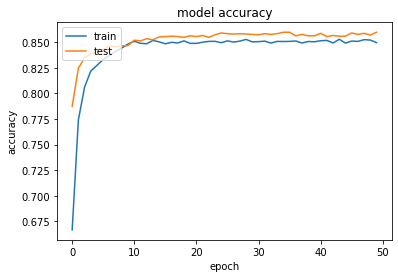

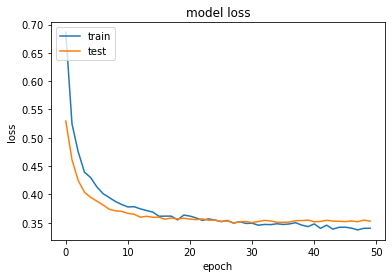

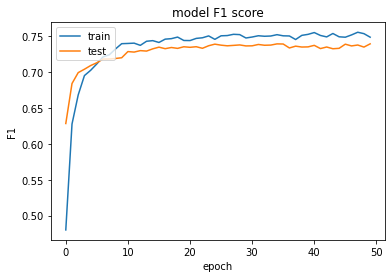




{0: 1, 1: 12.717077315208156}
________________________________
I'm training ANN number 1

0.07290182719108083
Train on 16145 samples, validate on 2850 samples
Epoch 1/50
16145/16145 [==============================] - 3s 172us/step - loss: 0.8056 - accuracy: 0.6900 - precision_m: 0.1139 - recall_m: 0.4202 - f1_m: 0.1703 - val_loss: 0.5635 - val_accuracy: 0.7435 - val_precision_m: 0.1536 - val_recall_m: 0.4875 - val_f1_m: 0.2181
Epoch 2/50
16145/16145 [==============================] - 2s 151us/step - loss: 0.6711 - accuracy: 0.6992 - precision_m: 0.1350 - recall_m: 0.5179 - f1_m: 0.2040 - val_loss: 0.5704 - val_accuracy: 0.7537 - val_precision_m: 0.1837 - val_recall_m: 0.5550 - val_f1_m: 0.2609
Epoch 3/50
16145/16145 [==============================] - 2s 152us/step - loss: 0.6270 - accuracy: 0.7034 - precision_m: 0.1519 - recall_m: 0.5793 - f1_m: 0.2275 - val_loss: 0.5536 - val_accuracy: 0.7695 - val_precision_m: 0.1989 - val_recall_m: 0.5810 - val_f1_m: 0.2797
Epoch 4/50
16145/16145

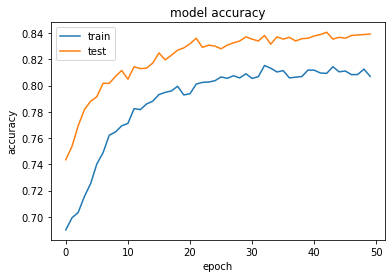

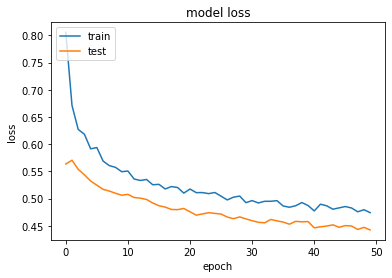

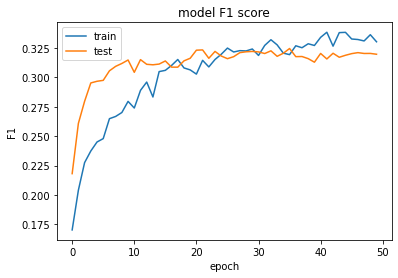




{0: 1, 1: 3.2110067814293166}
________________________________
I'm training ANN number 2

0.23747290182719108
Train on 16145 samples, validate on 2850 samples
Epoch 1/50
16145/16145 [==============================] - 3s 169us/step - loss: 0.8135 - accuracy: 0.5536 - precision_m: 0.2691 - recall_m: 0.5255 - f1_m: 0.3462 - val_loss: 0.6664 - val_accuracy: 0.6260 - val_precision_m: 0.3537 - val_recall_m: 0.5920 - val_f1_m: 0.4349
Epoch 2/50
16145/16145 [==============================] - 2s 154us/step - loss: 0.7130 - accuracy: 0.6078 - precision_m: 0.3186 - recall_m: 0.5819 - f1_m: 0.3994 - val_loss: 0.6397 - val_accuracy: 0.6586 - val_precision_m: 0.3840 - val_recall_m: 0.6069 - val_f1_m: 0.4620
Epoch 3/50
16145/16145 [==============================] - 3s 156us/step - loss: 0.6804 - accuracy: 0.6323 - precision_m: 0.3435 - recall_m: 0.5945 - f1_m: 0.4227 - val_loss: 0.6258 - val_accuracy: 0.6705 - val_precision_m: 0.4026 - val_recall_m: 0.6168 - val_f1_m: 0.4786
Epoch 4/50
16145/16145

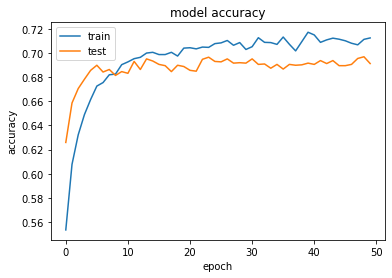

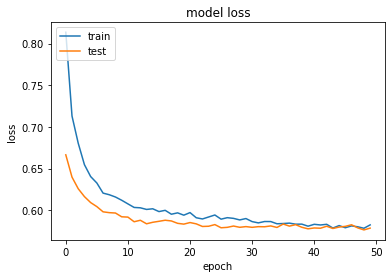

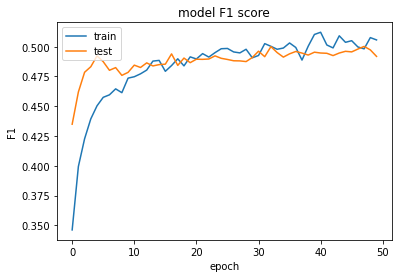




{0: 1, 1: 3.274556526343659}
________________________________
I'm training ANN number 3

0.23394239702694333
Train on 16145 samples, validate on 2850 samples
Epoch 1/50
16145/16145 [==============================] - 3s 170us/step - loss: 0.7514 - accuracy: 0.5751 - precision_m: 0.2785 - recall_m: 0.5024 - f1_m: 0.3468 - val_loss: 0.6464 - val_accuracy: 0.6453 - val_precision_m: 0.3599 - val_recall_m: 0.5734 - val_f1_m: 0.4312
Epoch 2/50
16145/16145 [==============================] - 3s 157us/step - loss: 0.6765 - accuracy: 0.6443 - precision_m: 0.3360 - recall_m: 0.5341 - f1_m: 0.3998 - val_loss: 0.6225 - val_accuracy: 0.6821 - val_precision_m: 0.3931 - val_recall_m: 0.5425 - val_f1_m: 0.4448
Epoch 3/50
16145/16145 [==============================] - 3s 181us/step - loss: 0.6560 - accuracy: 0.6719 - precision_m: 0.3657 - recall_m: 0.5417 - f1_m: 0.4222 - val_loss: 0.6153 - val_accuracy: 0.6944 - val_precision_m: 0.4153 - val_recall_m: 0.5686 - val_f1_m: 0.4693
Epoch 4/50
16145/16145 

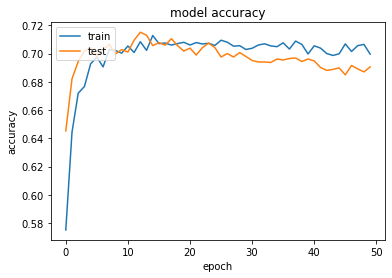

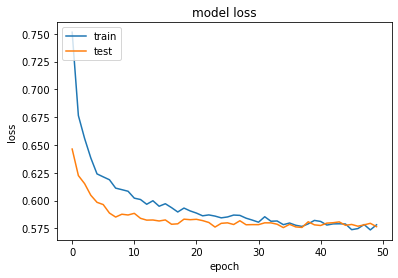

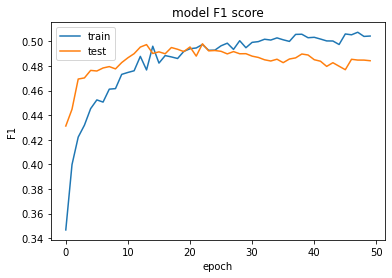




{0: 1, 1: 3.1913291796469365}
________________________________
I'm training ANN number 4

0.2385877980799009
Train on 16145 samples, validate on 2850 samples
Epoch 1/50
16145/16145 [==============================] - 3s 174us/step - loss: 0.8239 - accuracy: 0.5008 - precision_m: 0.2619 - recall_m: 0.6003 - f1_m: 0.3551 - val_loss: 0.6732 - val_accuracy: 0.6151 - val_precision_m: 0.3607 - val_recall_m: 0.6799 - val_f1_m: 0.4624
Epoch 2/50
16145/16145 [==============================] - 3s 158us/step - loss: 0.7093 - accuracy: 0.5916 - precision_m: 0.3212 - recall_m: 0.6323 - f1_m: 0.4145 - val_loss: 0.6391 - val_accuracy: 0.6646 - val_precision_m: 0.3988 - val_recall_m: 0.6572 - val_f1_m: 0.4865
Epoch 3/50
16145/16145 [==============================] - 3s 158us/step - loss: 0.6733 - accuracy: 0.6250 - precision_m: 0.3438 - recall_m: 0.6321 - f1_m: 0.4343 - val_loss: 0.6181 - val_accuracy: 0.6772 - val_precision_m: 0.4109 - val_recall_m: 0.6382 - val_f1_m: 0.4899
Epoch 4/50
16145/16145 

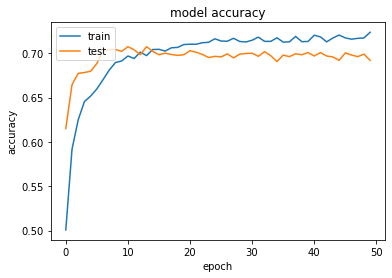

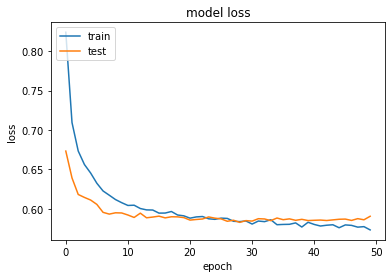

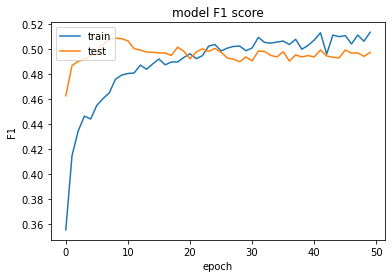




{0: 1, 1: 3.9448698315467077}
________________________________
I'm training ANN number 5

0.20222979250541964
Train on 16145 samples, validate on 2850 samples
Epoch 1/50
16145/16145 [==============================] - 3s 178us/step - loss: 0.8649 - accuracy: 0.5795 - precision_m: 0.2684 - recall_m: 0.6141 - f1_m: 0.3620 - val_loss: 0.6606 - val_accuracy: 0.6814 - val_precision_m: 0.3368 - val_recall_m: 0.6657 - val_f1_m: 0.4340
Epoch 2/50
16145/16145 [==============================] - 3s 160us/step - loss: 0.7174 - accuracy: 0.6518 - precision_m: 0.3195 - recall_m: 0.6306 - f1_m: 0.4112 - val_loss: 0.5902 - val_accuracy: 0.7130 - val_precision_m: 0.3608 - val_recall_m: 0.6669 - val_f1_m: 0.4552
Epoch 3/50
16145/16145 [==============================] - 3s 159us/step - loss: 0.6644 - accuracy: 0.6790 - precision_m: 0.3452 - recall_m: 0.6449 - f1_m: 0.4357 - val_loss: 0.5616 - val_accuracy: 0.7316 - val_precision_m: 0.3829 - val_recall_m: 0.6748 - val_f1_m: 0.4751
Epoch 4/50
16145/16145

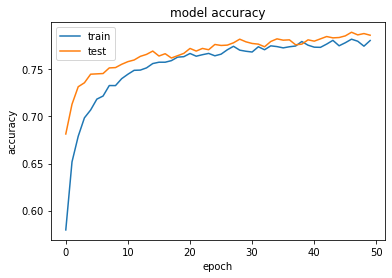

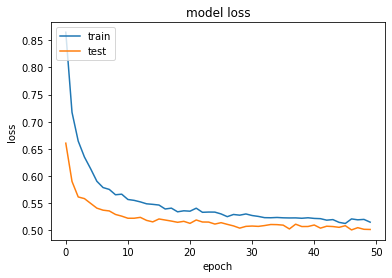

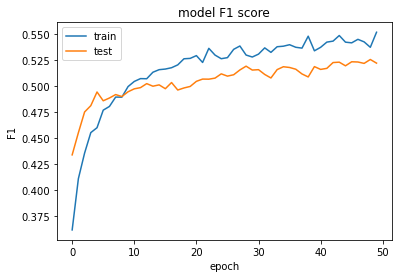




{0: 1, 1: 8.892769607843137}
________________________________
I'm training ANN number 6

0.10108392691235676
Train on 16145 samples, validate on 2850 samples
Epoch 1/50
16145/16145 [==============================] - 3s 172us/step - loss: 0.7680 - accuracy: 0.4788 - precision_m: 0.1306 - recall_m: 0.6978 - f1_m: 0.2139 - val_loss: 0.6939 - val_accuracy: 0.5540 - val_precision_m: 0.1610 - val_recall_m: 0.8295 - val_f1_m: 0.2615
Epoch 2/50
16145/16145 [==============================] - 3s 158us/step - loss: 0.6337 - accuracy: 0.5767 - precision_m: 0.1658 - recall_m: 0.7701 - f1_m: 0.2638 - val_loss: 0.6067 - val_accuracy: 0.6477 - val_precision_m: 0.1944 - val_recall_m: 0.8186 - val_f1_m: 0.3035
Epoch 3/50
16145/16145 [==============================] - 3s 159us/step - loss: 0.5777 - accuracy: 0.6413 - precision_m: 0.1949 - recall_m: 0.7853 - f1_m: 0.3013 - val_loss: 0.5672 - val_accuracy: 0.6740 - val_precision_m: 0.2078 - val_recall_m: 0.8140 - val_f1_m: 0.3191
Epoch 4/50
16145/16145 

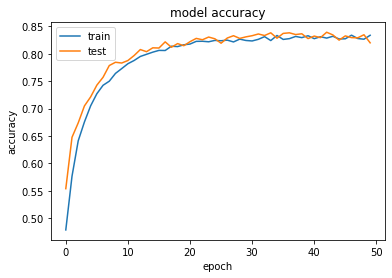

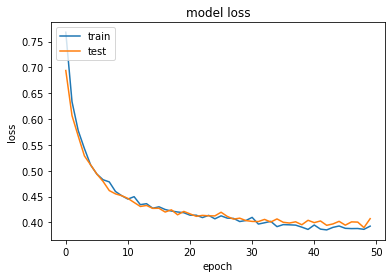

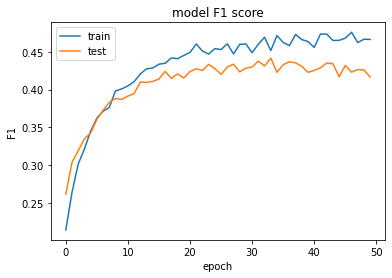




{0: 1, 1: 3.2498025796262175}
________________________________
I'm training ANN number 7

0.23530504800247753
Train on 16145 samples, validate on 2850 samples
Epoch 1/50
16145/16145 [==============================] - 3s 167us/step - loss: 0.7765 - accuracy: 0.6450 - precision_m: 0.3553 - recall_m: 0.6073 - f1_m: 0.4383 - val_loss: 0.6044 - val_accuracy: 0.7344 - val_precision_m: 0.4321 - val_recall_m: 0.6633 - val_f1_m: 0.5108
Epoch 2/50
16145/16145 [==============================] - 2s 154us/step - loss: 0.6582 - accuracy: 0.7132 - precision_m: 0.4295 - recall_m: 0.6571 - f1_m: 0.5040 - val_loss: 0.5565 - val_accuracy: 0.7589 - val_precision_m: 0.4663 - val_recall_m: 0.6532 - val_f1_m: 0.5294
Epoch 3/50
16145/16145 [==============================] - 2s 154us/step - loss: 0.6162 - accuracy: 0.7320 - precision_m: 0.4490 - recall_m: 0.6563 - f1_m: 0.5200 - val_loss: 0.5374 - val_accuracy: 0.7712 - val_precision_m: 0.4927 - val_recall_m: 0.6602 - val_f1_m: 0.5485
Epoch 4/50
16145/16145

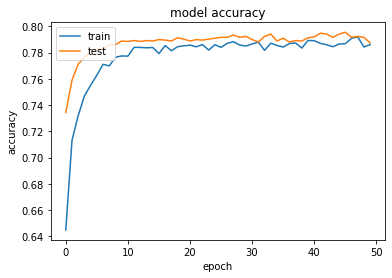

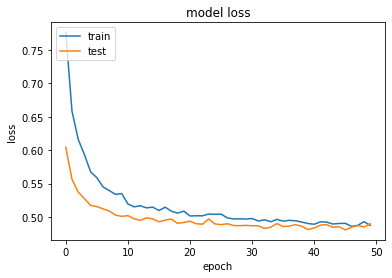

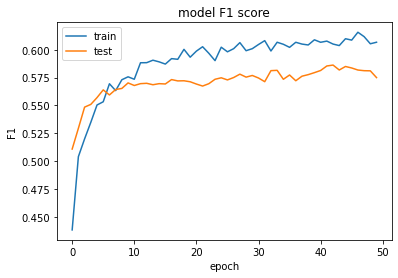




{0: 1, 1: 28.515539305301644}
________________________________
I'm training ANN number 8

0.03388045834623723
Train on 16145 samples, validate on 2850 samples
Epoch 1/50
16145/16145 [==============================] - 3s 165us/step - loss: 0.9030 - accuracy: 0.6177 - precision_m: 0.0424 - recall_m: 0.3391 - f1_m: 0.0734 - val_loss: 0.6015 - val_accuracy: 0.7186 - val_precision_m: 0.0625 - val_recall_m: 0.3607 - val_f1_m: 0.1030
Epoch 2/50
16145/16145 [==============================] - 2s 154us/step - loss: 0.7788 - accuracy: 0.6146 - precision_m: 0.0505 - recall_m: 0.3851 - f1_m: 0.0869 - val_loss: 0.6063 - val_accuracy: 0.7256 - val_precision_m: 0.0777 - val_recall_m: 0.4200 - val_f1_m: 0.1263
Epoch 3/50
16145/16145 [==============================] - 2s 152us/step - loss: 0.7164 - accuracy: 0.6196 - precision_m: 0.0511 - recall_m: 0.4154 - f1_m: 0.0888 - val_loss: 0.5958 - val_accuracy: 0.7337 - val_precision_m: 0.0777 - val_recall_m: 0.4200 - val_f1_m: 0.1272
Epoch 4/50
16145/16145

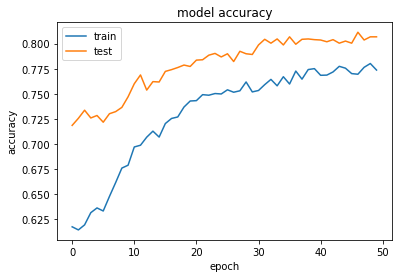

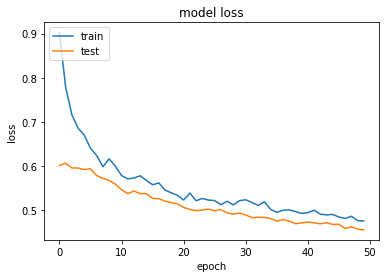

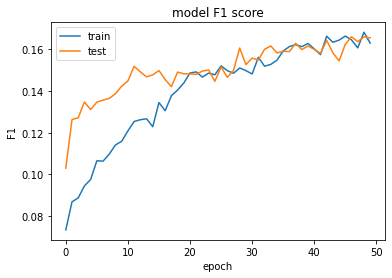




{0: 1, 1: 14.231132075471699}
________________________________
I'm training ANN number 9

0.06565500154846701
Train on 16145 samples, validate on 2850 samples
Epoch 1/50
16145/16145 [==============================] - 3s 167us/step - loss: 0.7826 - accuracy: 0.5176 - precision_m: 0.0945 - recall_m: 0.6425 - f1_m: 0.1595 - val_loss: 0.7243 - val_accuracy: 0.6365 - val_precision_m: 0.1471 - val_recall_m: 0.7361 - val_f1_m: 0.2320
Epoch 2/50
16145/16145 [==============================] - 3s 156us/step - loss: 0.5999 - accuracy: 0.6480 - precision_m: 0.1308 - recall_m: 0.6784 - f1_m: 0.2101 - val_loss: 0.5753 - val_accuracy: 0.7477 - val_precision_m: 0.1994 - val_recall_m: 0.7466 - val_f1_m: 0.2981
Epoch 3/50
16145/16145 [==============================] - 2s 152us/step - loss: 0.5283 - accuracy: 0.7187 - precision_m: 0.1624 - recall_m: 0.7101 - f1_m: 0.2536 - val_loss: 0.4904 - val_accuracy: 0.7989 - val_precision_m: 0.2348 - val_recall_m: 0.7266 - val_f1_m: 0.3355
Epoch 4/50
16145/16145

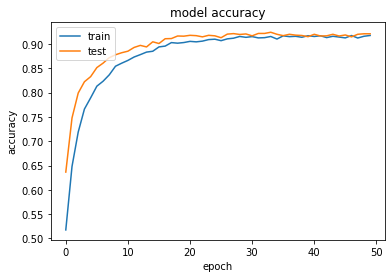

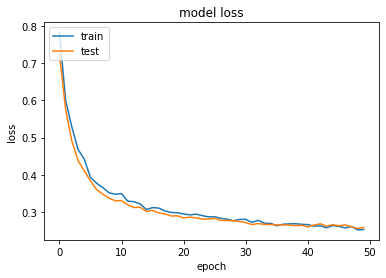

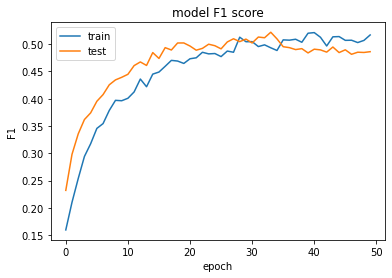

In [108]:
batch_size = 32
epochs = 50

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0,
                                  patience=20,
                                  verbose=0, mode='auto')

# Neural network
# Define ANN architecture

for i in range(10):
    ANN = Sequential()
    ANN.name = "ANN"
    if i == 2 or i == 3 or i ==4:
        N = 8
        dropout = 0.6
    else:
        N = 16
        dropout = 0.6
    ANN.add(Dense(N, activation='relu',input_dim=x_val.shape[1])) 
    ANN.add(Dropout(dropout))
#     ANN.add(Dense(32, activation='relu'))
#     ANN.add(Dropout(0.5))
#     ANN.add(Dense(32, activation='relu'))
#     ANN.add(Dropout(0.5))
#     ANN.add(Dense(32, activation='relu'))
#     ANN.add(Dropout(0.5))
#     ANN.add(Dense(50, activation='relu'))
#     ANN.add(Dropout(0.5))
    ANN.add(Dense(1, activation='sigmoid'))


    # class_custom_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
    # class_custom_weight = [1, 1000]
    class_custom_weight = {0: 1, 1: (1-custom_weight[i])/custom_weight[i]}
    print(class_custom_weight)
    
    print("________________________________")
    print("I'm training ANN number {:d}".format(i))
    print()

    optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.9, beta_2=0.999, amsgrad=False)
    ANN.compile(loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy', precision_m, recall_m, f1_m])
    
    class_custom_weight = class_weight.compute_class_weight('balanced', np.unique(y_train[:,i]), y_train[:,i])
    
    weights = np.zeros(y_train.shape[0])
    weights[y_train[:,i] == 1] = class_custom_weight[1]
    weights[y_train[:,i] == 0] = class_custom_weight[0]
#     weights[y_train[:,i] == 1] = 1/custom_weight[i]
#     weights[y_train[:,i] == 0] = 1
    print(custom_weight[i])
    class_custom_weight = {0: class_custom_weight[0], 1: class_custom_weight[1]}
    
    history = ANN.fit(x_train, y_train[:,i],
                        batch_size=batch_size,
                        epochs=epochs,
                        sample_weight = weights,
    #                        shuffle=True,
#                         class_weight = class_custom_weight,
                        verbose=1,
#                        callbacks= [EarlyStopping],
                        validation_data=(x_val, y_val[:,i]))

    ANN.summary() 
    score = ANN.evaluate(x_val, y_val[:,i], verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('Test precision:', score[2])
    print('Test recall:', score[3])
    print('Test F1:', score[4])
    
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for f1
    plt.plot(history.history['f1_m'])
    plt.plot(history.history['val_f1_m'])
    plt.title('model F1 score')
    plt.ylabel('F1')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    print()
    print()
    print()
    
    y_train_pred[:,i] = np.squeeze(ANN.predict(x_train)) 
    y_predict[:,i] = np.squeeze(ANN.predict(x_val))
#     prova_label_pred[i] = ANN.predict(prova.reshape(1,12,70))
    
    y_pred = ANN.predict(x_test)
    Output[LABEL[i]] = y_pred



{0: 1, 1: 16.32296137339056}
________________________________
I'm training ANN number 10

0.0577268504180861
Train on 16145 samples, validate on 2850 samples
Epoch 1/100
16145/16145 [==============================] - 4s 238us/step - loss: 0.9355 - accuracy: 0.6758 - precision_m: 0.0619 - recall_m: 0.2803 - f1_m: 0.0953 - val_loss: 0.9641 - val_accuracy: 0.3074 - val_precision_m: 0.0583 - val_recall_m: 0.5861 - val_f1_m: 0.1017
Epoch 2/100
16145/16145 [==============================] - 4s 221us/step - loss: 0.8478 - accuracy: 0.6935 - precision_m: 0.0640 - recall_m: 0.2812 - f1_m: 0.0995 - val_loss: 0.8871 - val_accuracy: 0.3867 - val_precision_m: 0.0618 - val_recall_m: 0.5200 - val_f1_m: 0.1060
Epoch 3/100
16145/16145 [==============================] - 3s 176us/step - loss: 0.8100 - accuracy: 0.7117 - precision_m: 0.0636 - recall_m: 0.2524 - f1_m: 0.0958 - val_loss: 0.8351 - val_accuracy: 0.4354 - val_precision_m: 0.0638 - val_recall_m: 0.4996 - val_f1_m: 0.1086
Epoch 4/100
16145/16145

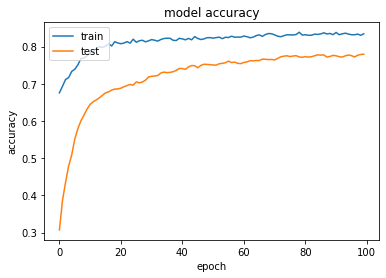

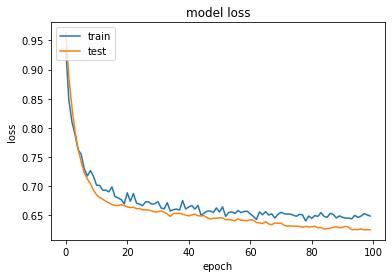

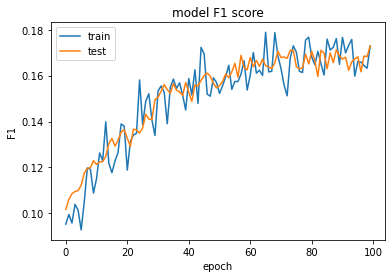

In [133]:
batch_size = 32
epochs = 100


# Neural network
# Define ANN architecture

for i in range(10,11):
    ANN = Sequential()
    ANN.name = "ANN"

    
    ANN.add(Dense(4, activation='relu',input_dim=x_val.shape[1])) 
    ANN.add(Dropout(0.75))
#     ANN.add(Dense(10, activation='relu'))
#     ANN.add(Dropout(0.5))
#     ANN.add(Dense(8, activation='relu'))
#     ANN.add(Dropout(0.5))
#     ANN.add(Dense(32, activation='relu'))
#     ANN.add(Dropout(0.5))
#     ANN.add(Dense(32, activation='relu'))
#     ANN.add(Dropout(0.5))
#     ANN.add(Dense(150, activation='relu'))
#     ANN.add(Dropout(0.5))
    ANN.add(Dense(1, activation='sigmoid'))


    # class_custom_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
    # class_custom_weight = [1, 1000]
    class_custom_weight = {0: 1, 1: (1-custom_weight[i])/custom_weight[i]}
    print(class_custom_weight)
    
    print("________________________________")
    print("I'm training ANN number {:d}".format(i))
    print()

    optimizer = optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    ANN.compile(loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy', precision_m, recall_m, f1_m])

    class_custom_weight = class_weight.compute_class_weight('balanced', np.unique(y_train[:,i]), y_train[:,i])
    
    weights = np.zeros(y_train.shape[0])
    weights[y_train[:,i] == 1] =class_custom_weight[1]
    weights[y_train[:,i] == 0] = class_custom_weight[0]
#     weights[y_train[:,i] == 1] = 1/custom_weight[i]
#     weights[y_train[:,i] == 0] = 1
    print(custom_weight[i])
    
#     weights = np.zeros(y_train.shape[0])
#     weights[y_train[:,i] == 1] =  1/custom_weight[i]
#     weights[y_train[:,i] == 0] = 1
#     print(custom_weight[i])
    
    history = ANN.fit(x_train, y_train[:,i],
                        batch_size=batch_size,
                        epochs=epochs,
                        sample_weight = weights,
    #                         shuffle=True,
#                         class_weight = class_custom_weight,
                        verbose=1,
                        validation_data=(x_val, y_val[:,i]))

    ANN.summary() 
    score = ANN.evaluate(x_val, y_val[:,i], verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('Test precision:', score[2])
    print('Test recall:', score[3])
    print('Test F1:', score[4])
    
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for f1
    plt.plot(history.history['f1_m'])
    plt.plot(history.history['val_f1_m'])
    plt.title('model F1 score')
    plt.ylabel('F1')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    print()
    print()
    print()
    
    y_train_pred[:,i] = np.squeeze(ANN.predict(x_train)) 
    y_predict[:,i] = np.squeeze(ANN.predict(x_val))
#     prova_label_pred[i] = ANN.predict(prova.reshape(1,12,70))
    
    y_pred = ANN.predict(x_test)
    Output[LABEL[i]] = y_pred



In [ ]:
print(x_train.shape)
print(y_train.shape)

clf = SVC(kernel='linear', probability=True,verbose = True, class_weight = 'balanced')
clf.fit(x_train, y_train[:,10])

a = clf.predict_proba(x_val)
print(a.shape)
print(a)
y_predict[:,10] = a[:,1]

(16145, 245)
(16145, 15)
[LibSVM]

________________________________
I'm training ANN number 13

Train on 16145 samples, validate on 2850 samples
Epoch 1/60
16145/16145 [==============================] - 4s 265us/step - loss: 877.7965 - val_loss: 381.0694
Epoch 2/60
16145/16145 [==============================] - 4s 242us/step - loss: 282.3752 - val_loss: 231.4275
Epoch 3/60
16145/16145 [==============================] - 4s 245us/step - loss: 198.5874 - val_loss: 405.7941
Epoch 4/60
16145/16145 [==============================] - 4s 247us/step - loss: 155.5659 - val_loss: 234.5005
Epoch 5/60
16145/16145 [==============================] - 4s 257us/step - loss: 121.1069 - val_loss: 263.0793
Epoch 6/60
16145/16145 [==============================] - 4s 265us/step - loss: 99.2758 - val_loss: 155.1697
Epoch 7/60
16145/16145 [==============================] - 5s 290us/step - loss: 70.7587 - val_loss: 24.4908
Epoch 8/60
16145/16145 [==============================] - 4s 262us/step - loss: 55.9338 - val_loss: 6.4824
Epoch 9/60
16145

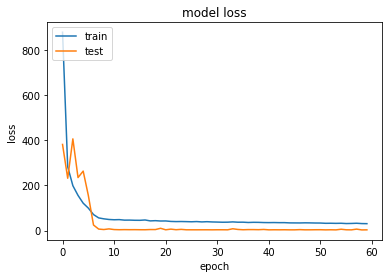

In [125]:
batch_size = 32
epochs = 60

for i in range(11,15):
    ANN = Sequential()
    ANN.name = "ANN"
    if i == 11:
        N = 450
        dropout = 0.5
    if i == 12:
        N = 400
        dropout = 0.5
    if i == 13:
        N = 300
        dropout = 0.3
    if i == 14:
        N = 250
        dropout = 0.3
        
        
    ANN.add(Dense(N, activation='relu',input_dim=x_val.shape[1]))
    ANN.add(Dropout(dropout))
    ANN.add(Dense(N, activation='relu'))
    ANN.add(Dropout(dropout))
    ANN.add(Dense(N, activation='relu'))
    ANN.add(Dropout(dropout))
    ANN.add(Dense(N, activation='relu'))
    ANN.add(Dropout(dropout))
    ANN.add(Dense(N, activation='relu'))
    ANN.add(Dropout(dropout))
#     ANN.add(Dense(200, activation='relu'))
#     ANN.add(Dropout(0.35))

    ANN.add(Dense(1, activation='linear'))
 
    
    print("________________________________")
    print("I'm training ANN number {:d}".format(i))
    print()
    
    optimizer = optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
    ANN.compile(loss='mse',
                optimizer=optimizer)


    history = ANN.fit(x_train, y_train[:,i],
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_val, y_val[:,i]))

    ANN.summary() 
    score = ANN.evaluate(x_val, y_val[:,i], verbose=1)
    print('Test loss:', score)
    
    # list all data in history
    print(history.history.keys())

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    print()
    print()
    print()
    
    y_train_pred[:,i] = np.squeeze(ANN.predict(x_train)) 
    y_predict[:,i] = np.squeeze(ANN.predict(x_val))
#     prova_label_pred[i] = ANN.predict(prova.reshape(1,12,70))

    y_pred = ANN.predict(x_test)
    Output[LABEL[i]] = y_pred

In [15]:
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDRegressor


In [33]:
clf = SGDRegressor( tol = 1e-5, verbose = 1 ,n_iter_no_change  = 5 , alpha = 0.00000828 ,learning_rate = 'adaptive' ,eta0 = 0.008, max_iter = 2000)
# clf = LinearSVR(random_state=0, tol=1e-5, verbose = 1)

feature_map_nystroem = Nystroem(n_components=245,gamma = 1/245)
kernel_transform = feature_map_nystroem.fit(x_train)
data_transformed = kernel_transform.transform(x_train)
clf.fit(data_transformed, y_train[:,12])




-- Epoch 1
Norm: 62.35, NNZs: 245, Bias: 80.917008, T: 17095, Avg. loss: 60.555694
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 70.60, NNZs: 245, Bias: 82.330795, T: 34190, Avg. loss: 39.027333
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 75.48, NNZs: 245, Bias: 81.354061, T: 51285, Avg. loss: 38.152720
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 78.61, NNZs: 245, Bias: 82.634349, T: 68380, Avg. loss: 37.674342
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 82.28, NNZs: 245, Bias: 82.658183, T: 85475, Avg. loss: 37.370400
Total training time: 0.07 seconds.
-- Epoch 6
Norm: 84.86, NNZs: 245, Bias: 81.800219, T: 102570, Avg. loss: 37.089075
Total training time: 0.08 seconds.
-- Epoch 7
Norm: 88.13, NNZs: 245, Bias: 82.553384, T: 119665, Avg. loss: 36.851839
Total training time: 0.10 seconds.
-- Epoch 8
Norm: 90.89, NNZs: 245, Bias: 82.993361, T: 136760, Avg. loss: 36.664332
Total training time: 0.11 seconds.
-- Epoch 9
Norm: 93.17, NNZs: 245, Bias: 82.386781, T

SGDRegressor(alpha=8.28e-06, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.008, fit_intercept=True, l1_ratio=0.15,
             learning_rate='adaptive', loss='squared_loss', max_iter=2000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=1e-05, validation_fraction=0.1, verbose=1,
             warm_start=False)

In [34]:
print(clf.score(data_transformed,y_train[:,12]))
val_transformed = kernel_transform.transform(x_val)

print(clf.score(val_transformed,y_val[:,12]))

0.5783528957006874
0.5637409580444894


In [26]:
scaler = StandardScaler()
scaler.fit(data)
data_scaled = scaler.transform(data)

feature_map_nystroem = Nystroem(n_components=245,gamma = 1/245)

score = np.zeros([100,100])
i = 0

for alpha in np.linspace(0,0.00001,100):
    j = 0
    for eta0 in np.linspace(0.001,0.01,10):
        clf = SGDRegressor( tol = 1e-5 ,n_iter_no_change  = 5 , alpha = alpha ,learning_rate = 'adaptive' ,eta0 = eta0, max_iter = 2000)
        print('alpha = {:.5f}'.format(alpha))
        print('eta0 = {:.4f}'.format(eta0))
        kernel_transform = feature_map_nystroem.fit(data_scaled)
        data_transformed = kernel_transform.transform(data_scaled)
        score[i,j] = np.mean(cross_val_score(clf,data_transformed,data_labels[:,12],scoring = 'r2',cv = 5))
        print(score[i,j])
        j = j + 1
    i = i + 1 
  
max_sc = np.max(score)
ind = np.where(score == np.max(score))

print(ind)
        
        

alpha = 0.00000
eta0 = 0.0010
0.35953984896051167
alpha = 0.00000
eta0 = 0.0020
0.367390141508675
alpha = 0.00000
eta0 = 0.0030
0.3657112436550498
alpha = 0.00000
eta0 = 0.0040
0.36778006170450694
alpha = 0.00000
eta0 = 0.0050
0.3690241953041833
alpha = 0.00000
eta0 = 0.0060
0.36723743423599253
alpha = 0.00000
eta0 = 0.0070
0.3662290510913092
alpha = 0.00000
eta0 = 0.0080
0.36856987136441555
alpha = 0.00000
eta0 = 0.0090
0.3701798012335607
alpha = 0.00000
eta0 = 0.0100
0.3690862609404678
alpha = 0.00000
eta0 = 0.0010
0.3661174858187195
alpha = 0.00000
eta0 = 0.0020
0.3652902625707676
alpha = 0.00000
eta0 = 0.0030
0.3649563061844553
alpha = 0.00000
eta0 = 0.0040
0.3680041761790637
alpha = 0.00000
eta0 = 0.0050
0.3649603166416031
alpha = 0.00000
eta0 = 0.0060
0.36556352072905607
alpha = 0.00000
eta0 = 0.0070
0.3687268694515763
alpha = 0.00000
eta0 = 0.0080
0.365949189232919
alpha = 0.00000
eta0 = 0.0090
0.3657490744556844
alpha = 0.00000
eta0 = 0.0100
0.3669022359184099
alpha = 0.00000
e

In [31]:
print(max_sc)
A = np.linspace(0,0.00001,100)
E = np.linspace(0.001,0.01,10)
print('alpha = {:.8f}'.format(A[82]) + ', eta0 = ' + str(E[7]))


0.37473192278535866
alpha = 0.00000828, eta0 = 0.008


In [143]:
score = np.zeros([y_train.shape[1]])
score_train = np.zeros([y_train.shape[1]])
for i in range(11):
    score[i] = roc_auc_score(y_val[:,i],y_predict[:,i])
    score_train[i] = roc_auc_score(y_train[:,i],y_train_pred[:,i])
        
for i in range(11,15):
    score[i] = r2_score(y_val[:,i],y_predict[:,i])
    score_train[i] = r2_score(y_train[:,i],y_train_pred[:,i])
    

In [144]:
print("task 1:")
print("test:" + str(np.around(score[0:10],3)))
print("train:" + str(np.around(score_train[0:10],3)))
print("task 2:")
print("test:" + str(np.around(score[10],3)))
print("train:" + str(np.around(score_train[10],3)))
print("task 3:") 
print("test:" + str(np.around(score[11:],3)))
print("train:" + str(np.around(score_train[11:],3)))

task 1:
test:[0.923 0.806 0.743 0.74  0.739 0.813 0.89  0.829 0.805 0.934]
train:[0.943 0.888 0.791 0.793 0.795 0.847 0.926 0.867 0.896 0.975]
task 2:
test:0.7
train:0.779
task 3:
test:[0.319 0.578 0.274 0.595]
train:[0.433 0.66  0.445 0.741]


In [128]:
# 64 * 0.75 0.00003
# test:0.745
# train:0.819




# 16 * 0.5
# test:[0.936 0.832 0.749 0.753 0.751 0.807 0.89  0.837 0.731 0.939]
# train:[0.936 0.874 0.782 0.785 0.786 0.837 0.925 0.859 0.878 0.97 ]
    
# 32 * 0.5
# test:[0.936 0.836 0.758 0.758 0.749 0.809 0.885 0.839 0.715 0.939]
# train:[0.942 0.893 0.799 0.8   0.797 0.852 0.934 0.87  0.914 0.977]

In [129]:
task1 = np.mean(score[0:10])
print("task1 is {}".format(task1))
task2 = score[10]
print("task2 is {}".format(task2))
print()


task3 = np.mean(0.5 + 0.5 *np.maximum(0,score[11:]))
print("task3 is {}".format(task3))

score_d = np.mean([task1, task2, task3])
print(task1, task2, task3)
print()
print("score is {}".format(score_d))

task1 is 0.8222144816202338
task2 is 0.6900995564692669

task3 is 0.7207371389832089
0.8222144816202338 0.6900995564692669 0.7207371389832089

score is 0.74435039235757


In [115]:
task1 = np.mean(score_train[0:10])
print("task1 training is {}".format(task1))
task2 = score_train[10]
print("task2 training is {}".format(task2))
print()


task3 = np.mean(0.5 + 0.5 *np.maximum(0,score_train[11:]))
print("task3 training is {}".format(task3))

score_d = np.mean([task1, task2, task3])
print(task1, task2, task3)
print()
print("training score  is {}".format(score_d))

task1 training is 0.8723071764949367
task2 training is 0.829196158469617

task3 training is 0.5
0.8723071764949367 0.829196158469617 0.5

training score  is 0.7338344449881845


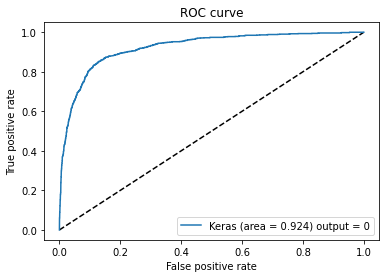

F1 score: for i = 0 :
0.7773351040283312
165
338


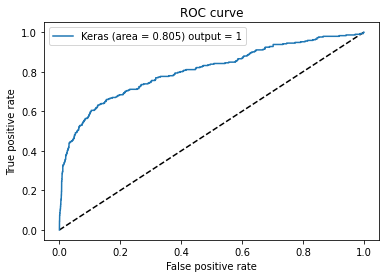

F1 score: for i = 1 :
0.373046875
100
542


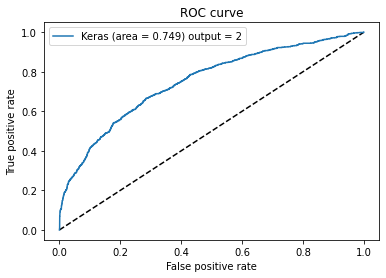

F1 score: for i = 2 :
0.5198125266297401
307
820


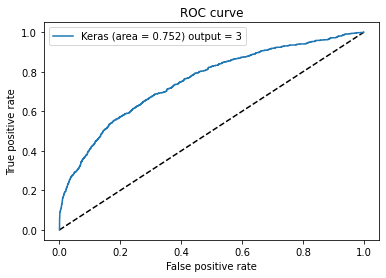

F1 score: for i = 3 :
0.508870618779749
308
827


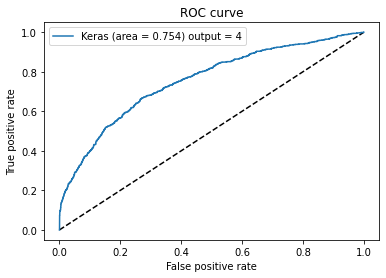

F1 score: for i = 4 :
0.5242966751918159
299
817


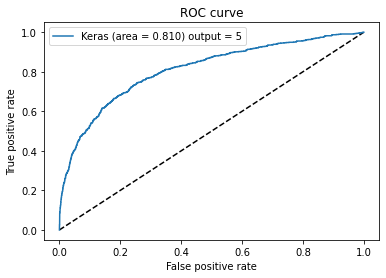

F1 score: for i = 5 :
0.5480532281912273
232
685


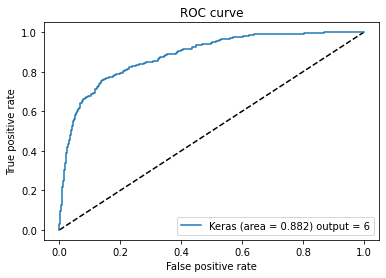

F1 score: for i = 6 :
0.45020242914979763
81
598


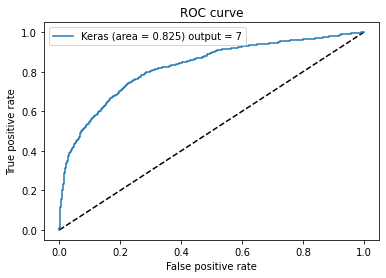

F1 score: for i = 7 :
0.600663192799621
271
572


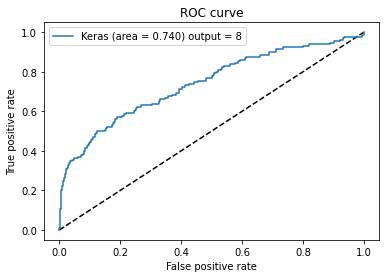

F1 score: for i = 8 :
0.16666666666666669
62
618


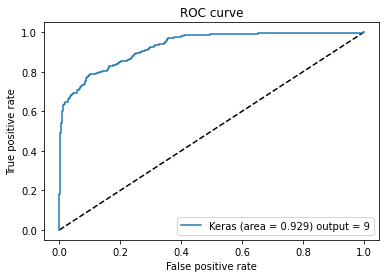

F1 score: for i = 9 :
0.5405405405405406
72
251


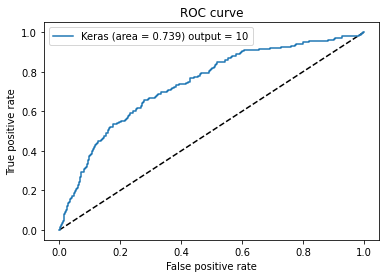

F1 score: for i = 10 :
0.2040485829959514
84
899


In [33]:
score = np.zeros([y_train.shape[1]])
score_train = np.zeros([y_train.shape[1]])

for i in range(11):
    fpr, tpr, thresholds = roc_curve(y_val[:,i], y_predict[:,i])
    auc = sklearn.metrics.auc(fpr, tpr)
    roc_auc_score(y_val[:,i],y_predict[:,i])
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='Keras (area = {:.3f}) output = {}'.format(auc,i))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    score[i] = auc
    score_train[i] = roc_auc_score(y_train[:,i],y_train_pred[:,i])
    
    print("F1 score: for i = {:d} :".format(i))
    print(f1_score(y_val[:,i], np.around(y_predict[:,i])))
    a = y_val[:,i] - np.around(y_predict[:,i])
    print(sum(a>0))
    print(sum(a<0))
    
for i in range(11,15):
    score[i] = r2_score(y_val[:,i],y_predict[:,i])
    score_train[i] = r2_score(y_train[:,i],y_train_pred[:,i])

In [34]:
from sklearn.metrics import confusion_matrix
for i in range(11):
    print(i)
#     print("val:")
    print(confusion_matrix(y_val[:,i],np.around(y_predict[:,i])).ravel())
#     print("train:")
#     print(confusion_matrix(y_train[:,i],np.around(y_train_pred[:,i])).ravel())
# tn, fp, fn, tp 

0
[2418  338  165  878]
1
[2966  542  100  191]
2
[2062  820  307  610]
3
[2076  827  308  588]
4
[2068  817  299  615]
5
[2326  685  232  556]
6
[2842  598   81  278]
7
[2322  572  271  634]
8
[3051  618   62   68]
9
[3286  251   72  190]
10
[2690  899   84  126]


In [35]:
compression_opts = dict(method='zip',
                        archive_name='prediction.csv')  
Output.to_csv('prediction.zip', index=False,float_format='%.3f',
          compression=compression_opts)  